# Histopathologic Cancer Detection

# 1. Installing libraries, downloading the dataset

In [98]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

We are not allowed to share the dataset. Download the dataset from Kaggle by pip installing kaggle, and running `kaggle competitions download -c histopathologic-cancer-detection` in your terminal. Then, extract files from the histopathologic-cancer-detection.zip folder into a new folder called 'data'.

In [99]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 80000 # the number of images we use from each of the two classes

In [100]:
# See image count in each folder
print(len(os.listdir('data/train')))
print(len(os.listdir('data/test')))

220025
57458


# 2. Data Pre-processing

Now that the data has been properly loaded and set-up, we must now pre-process our data: in our case, we mainnly subset the data, augment the images, and split it into train and test.

Note: The data takes hours to download in its full size, leaving a high possibility of crashing the kernel, not to mention the time required to train the model. Thus, we slightly modified someone else's preprocessing instructions throughout this entire stage to get a smaller subset of the data. This will make it faster and easier for us to run and train our model.

https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

## Removing anomalous images

In [101]:
# Create a Dataframe containing all images
data = pd.read_csv('data/train_labels.csv')

# Removing this image because it caused a training error previously
data[data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# Removing this image because it's black
data[data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(data.shape)

(220025, 2)


## Augmenting image data

Justification for augmentation

This Kaggle challenge is a Machine Learning challenge. Machine learning however, requires plenty and diverse training data to accurately predict future data points without overfitting or underfitting. We have a lot of data points already, but also want to diversify them to prevent overfitting to the original data that may be too similar to each other already. We decided to augment the images in order to increase the diversity of images as inspired by this github repo below.

https://github.com/aleju/imgaug

In [102]:
#Function for augmenting data
from skimage.transform import rotate, AffineTransform
import cv2
from skimage.util import random_noise
import random
import os
from skimage import io
from skimage import img_as_ubyte

ORIGINAL_SIZE = IMAGE_SIZE      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

def readCroppedImage(path, augmentations = True):
    '''
    This is a custom function to convert an input image, augment it through
    random rotation, random x or y shift, random cropping, random flipping, 
    random changes in brightness and contrast, and returning it as an rgb tensor.
    '''
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return img_as_ubyte(rgb_img)

In [103]:
#Augment test images randomly

images_path="data/train" #path to original images
augmented_path="data/train" # path to store augmented images
images=[] # to store paths of images from folder

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))

images_to_generate=10000 #you can change this value according to your requirement

for i in range(images_to_generate):    
    image=random.choice(images)
    id = image[11:-4]
    label = data[data['id'] == id].iloc[0]['label']
    data = data.append({"id":'augmented_'+id,'label':label},ignore_index=True)
    transformed_image= readCroppedImage(image)
    new_image_path= "data/train/augmented_%s.tif" %(id)
    print(new_image_path)
    cv2.imwrite(new_image_path, transformed_image) # save transformed image to path

#Save new label file which has the augmented images
data.to_csv('data/new_train_labels.csv')
data.shape

f
data/train/augmented_2d8ef4008fb380d79f7da2207e1ef874a0b57771.tif
data/train/augmented_e6480906ad4a0bc2d115d21b8a166a64ec5deb68.tif
data/train/augmented_ca8d4902c62e5d892c31f742851b05f0f58069bc.tif
data/train/augmented_40a49247a96cca38382ce942f968af98d73f52c0.tif
data/train/augmented_fb45ff1ad7e35b0a9a3e31ad9684e987064d15b3.tif
data/train/augmented_49e84ecc96fa2efd589d1b3439f0a6da1f0c93de.tif
data/train/augmented_95a945865b2a21ca26598a04841c5ad66a3888a4.tif
data/train/augmented_f5f8d4fc5fbe4f1117856fb089a67a992b76f2da.tif
data/train/augmented_56555b97da85148fcb3a86ee40ed152b8c2cb2c8.tif
data/train/augmented_4ada2fce5b2629dd99124835f6db0168e66b41f8.tif
data/train/augmented_72d3288fd33298fa4877f6aa2502edae01c8fd4b.tif
data/train/augmented_64357f73582077d4b2d9639fd5e08fd55f7aad9f.tif
data/train/augmented_325bd81e3c7a6d8cdac9d3092d7dc9f323e673e5.tif
data/train/augmented_7b0f434fa3584667724ac24de33441ec0443f718.tif
data/train/augmented_773c6ccf0fad177d92a35c8e341ff072eddd19a2.tif
data/tra

(230025, 2)

In [104]:
# Load the new csv that now includes the augmented images 
df_data = pd.read_csv('data/new_train_labels.csv')

# Check the class distribution
df_data['label'].value_counts()

0    136792
1     93233
Name: label, dtype: int64

## Balance the target distribution

As decided earlier with the variable SAMPLE_SIZE, we will subset our original data into 160000 images half labelled 0, the other labelled 1.

In [105]:
# Load the new csv that now includes the augmented images 
df_data = pd.read_csv('data/new_train_labels.csv')

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [106]:
df_data.head()

,Unnamed: 0,id,label
59256,15213,03ff02aad3e6a2e59af41435e0ab83a048148e7b,0
47458,106796,4138f63457be8bc056e9262003655e37064d25b6,0
114606,217808,a3ee2c7df2c169f8ee83d868e5fc8e753145b7a1,1
106357,174926,641b5f9e09ec73fcf1078c50de8beb77a369e06a,1
1383,40395,342053ed552d92ae9ea7b62f4ead5847e7c45984,0


In [107]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 3)
(16000, 3)


In [108]:
# Check the training set counts
df_train['label'].value_counts()

1    72000
0    72000
Name: label, dtype: int64

In [109]:
# Check the validation set counts
df_val['label'].value_counts()

1    8000
0    8000
Name: label, dtype: int64

## Directory structure for image generators

## Creating the folders

In [110]:
# Create a new directory
base_dir = 'data/base_dir'
os.mkdir(base_dir)

#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [111]:
# check that the folders have been created
os.listdir('data/base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

## Splitting images into folders

In [113]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

KeyError: "None of ['id'] are in the columns"

In [114]:
train_list[1]

'7580260da07a5b6ffa7af74ac1e53b07d1c75bd8'

In [115]:
df_data.head(n=1)

,Unnamed: 0,label
id,,
03ff02aad3e6a2e59af41435e0ab83a048148e7b,15213,0


In [116]:
# Transfer the train images
count = 0

for image in train_list:
    count += 1
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']

    # these must match the folder names
    if target.any() == 0:
        label = 'a_no_tumor_tissue'
    if target.any() == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('data/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target.any() == 0:
        label = 'a_no_tumor_tissue'
    if target.any() == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('data/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [118]:
# check how many train images we have in each folder
print(len(os.listdir('data/base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('data/base_dir/train_dir/b_has_tumor_tissue')))

71961
71928


In [119]:
# check how many val images we have in each folder
print(len(os.listdir('data/base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('data/base_dir/val_dir/b_has_tumor_tissue')))


8000
8000


## Setting up the generators

In [120]:
train_path = 'data/base_dir/train_dir'
valid_path = 'data/base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [121]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

Found 143889 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


# 4. Model creation & assessment

This is the stage where we create a model that trains on the data. In our case, we chose to manually create a neural network model implemented with the keras library. We created a feedforward neural network with 24 layers all using the relu activation function.

## Logistic Regression Model

## Manually built CNN Model

In [ ]:
# Model architecture
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

# Neural network creation and layer adding
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

# Key details for each layer
model.summary()

# Compile the model
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

# Get the labels that are associated with each index
print(val_gen.class_indices)

### Training

In [ ]:
# Train through 20 epochs in hopes to improve accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=0, mode='max', min_lr=0.00001)
                                                      
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=0,
                   callbacks=callbacks_list)

# Train through 20 epochs in hopes to improve accuracy

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=0, mode='max', min_lr=0.00001)
                                                      
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=0,
                   callbacks=callbacks_list)

model.save("cnn_model.h5")

# convert the history.history dict to a pandas DataFrame:     
hist_df= pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = 'cnn_model_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## VGG16 Model

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

# VGG model without the last classifier layers (include_top = False)
vgg16_model = VGG16(include_top = False,
                    input_shape = (96,96,3),
                    #weights='../input/VGG16weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
                    weights = 'imagenet')
    
# Freeze the layers 
for layer in vgg16_model.layers[:-12]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in vgg16_model.layers:
    print(layer, layer.trainable)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras import optimizers

model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

model.compile(loss='binary_crossentropy',optimizer=optimizers.SGD(lr=0.00001, momentum=0.95),metrics=['accuracy'])

In [ ]:
### Train the model using the train set

checkpoint_2 = ModelCheckpoint(filepath_2, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr_2 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=0, mode='max', min_lr=0.00001)
                              
                              
callbacks_list_2 = [checkpoint_2, reduce_lr_2]

history_2 =  model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=0,
                   callbacks=callbacks_list_2)

# convert the history.history dict to a pandas DataFrame:     
hist_df= pd.DataFrame(history_2.history) 

# or save to csv: 
hist_csv_file = 'vgg16_model_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# 4. Evaluating our model

In this section, we will load our CNN model (model.h5) and use it to classify images in the test set. We will then plot the confusion matrix, AUC-ROC, and submit our results to Kaggle and check out our ranking. 

In [154]:
from tensorflow.keras.models import load_model

##### Load the model
model.load_weights('model.h5')

val_loss, val_acc = model.evaluate(val_gen, steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

1600/1600 [==============================] - 62s 39ms/step - loss: 0.3177 - accuracy: 0.8648
val_loss: 0.31770581007003784
val_acc: 0.8647500276565552


In [155]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

NameError: name 'history' is not defined

In [156]:
#Predict on validation set

Y_pred = model.predict(x = val_gen, batch_size = num_val_samples//val_batch_size)

<class 'numpy.ndarray'>


In [199]:
y_preds = pd.DataFrame(Y_pred, columns=['no_tumor_tissue', 'has_tumor_tissue'])
y_preds.head()
threshold = 0.9
y_preds['label'] = (y_preds['has_tumor_tissue'] > threshold).astype(int)
y_preds.head()
pred_label = y_preds['label']
cm = confusion_matrix(val_gen.classes, pred_label)
print(cm)

[[5239 2761]
 [5258 2742]]


In [200]:
# Plot non-normalized confusion matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
print(classification_report(val_gen.classes, pred_label, target_names=['No tumor','Has tumor']))

              precision    recall  f1-score   support

    No tumor       0.50      0.65      0.57      8000
   Has tumor       0.50      0.34      0.41      8000

    accuracy                           0.50     16000
   macro avg       0.50      0.50      0.49     16000
weighted avg       0.50      0.50      0.49     16000



In [203]:
from sklearn.metrics import roc_curve,roc_auc_score, plot_roc_curve

# false-positive rate, true-positive rate, thresholds
fpr, tpr, thresholds = roc_curve (val_gen.classes, y_pred)

print(roc_auc_score(val_gen.classes, y_pred))


0.5031249999999999


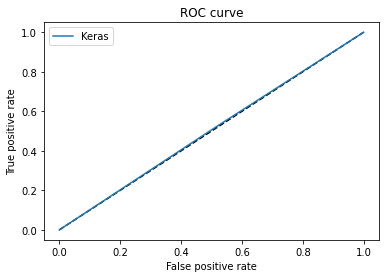

In [146]:
# Code adapted from https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Kaggle submission
Preparing the generators, producing the classifications and uploading it to Kaggle

In [209]:
# create test_dir
test_dir = 'data/test_dir'
os.mkdir(test_dir)

# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [210]:
# Transfer the test images into image_dir

test_list = os.listdir('data/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('data/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [211]:
num_test_samples = len(test_list)
test_batch_size = 10
test_steps = np.ceil(num_test_samples / test_batch_size)
datagen = ImageDataGenerator(rescale=1.0/255)

test_gen = datagen.flow_from_directory('data/test_dir',
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=test_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [212]:
Y_preds = model.predict_generator(test_gen, steps=test_steps, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
5746/5746 [==============================] - 212s 37ms/step


In [213]:
# Put the predictions into a dataframe

Y_preds = pd.DataFrame(Y_pred, columns=['no_tumor_tissue', 'has_tumor_tissue'])

Y_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.016003,0.983997
1,0.018343,0.981657
2,0.073720,0.926280
3,0.605464,0.394536
4,0.974464,0.025536


In [ ]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames
print(test_filenames[:5])


# 5. Interpreting our model

We now attempt to interpret our convolutional neural network model, to understand what features in an image are important to classifying it as showing a breast tumor or not. 

LIME (locally interpretable model-agnostic explainer) will be used, as is conventional for image classification.